In [14]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.ndimage import zoom
from scipy.interpolate import interp1d

In [15]:
# Function to interpolate and normalize the data
def interpolate_and_normalize(data, norm_factor, scale_factor):
    data = (data * norm_factor) * scale_factor  # Apply normalization
    data = zoom(data, ((inter_lat/hemisphere_lat), (inter_long/max_long)), order=1)  # Interpolate over latitude and longitude
    return data

In [16]:
def get_latitude_indices(lat_ind, lat_size):
    lat_df = pd.read_csv('latitude_table.txt', sep='\s+', header=0)
    lat_df = lat_df.dropna(axis=1)
    lat_df = lat_df.drop(lat_df.columns[0], axis=1)
    lat_df.columns = ['rad', 'colat']
    lat_df['lat'] = lat_df['colat'] - 90

    latitudes = lat_df['lat'].iloc[0:lat_ind].values
    indices = np.linspace(0, len(latitudes) - 1, lat_size)
    interp_func = interp1d(np.arange(len(latitudes)), latitudes, kind='linear')
    interpolated_latitudes = np.flip(interp_func(indices))

    return interpolated_latitudes

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_26735/890128796.py:2: SyntaxWarning: invalid escape sequence '\s'
  lat_df = pd.read_csv('latitude_table.txt', sep='\s+', header=0)


In [29]:
folder_path = f'/run/media/sachin/0fa21ddb-f70c-4238-9cf4-705e0360f1c1/Test/'

max_long, max_lat = 321, 221  # Maximum longitude and latitude per the raw files
inter_long, inter_lat = 180, 40 # Desired lon/mlt size, desired lat size,
hemisphere_lat = 63  #Size of lat per hemisphere 50 to 90 = 62 indices
hemi = 'NH'  # Hemisphere to select
latitudes = get_latitude_indices(hemisphere_lat, inter_lat)
feature = 'pot' #options: 'pot', 'fac', 'sxx', 'syy', 'sxy'
fac_norm = 3.75e-6  # A/m^2 for FAC
pot_norm = 1.017e7  # V for potential
cond_norm = 15  # S/m for conductivity

dt_str = '202008010000'  # Date and time of the data
date_obj = pd.to_datetime(dt_str, format='%Y%m%d%H%M')

datasets = []
for file_name in os.listdir(folder_path):
    with open(os.path.join(folder_path, file_name), 'r') as f:
        _ = np.fromfile(f, dtype=np.int32, count=1)[0]  # Count
        _ = np.fromfile(f, dtype=np.float32, count=1)[0]  # Time
        _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))  # vx
        _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))  # vy
        _ = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))  # vz
        pot = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
        fac = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
        sxx = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
        syy = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))
        sxy = np.fromfile(f, dtype=np.float32, count=max_long*max_lat).reshape((max_lat, max_long))

        # Select hemisphere
        if hemi == 'NH':
            s_ind, e_ind = (max_lat - 1) - hemisphere_lat, max_lat - 1
        else:
            s_ind, e_ind = 0, hemisphere_lat

        # Extract the feature data
        feature_data = {
            'pot': pot[s_ind:e_ind, :],
            'fac': fac[s_ind:e_ind, :],
            'sxx': sxx[s_ind:e_ind, :],
            'syy': syy[s_ind:e_ind, :],
            'sxy': sxy[s_ind:e_ind, :]
        }[feature] # Select the feature

        # Apply normalization and interpolation based on the feature
        if feature == 'pot':
            feature_data = interpolate_and_normalize(feature_data, pot_norm, scale_factor=1e-3)  # Convert V to kV
        elif feature == 'fac':
            feature_data = interpolate_and_normalize(feature_data, fac_norm, scale_factor=1e6) # Convert A/m^2 to uA/m^2
        else:
            feature_data = interpolate_and_normalize(feature_data, cond_norm, scale_factor=1) # No conversion for conductivity


        ds = xr.Dataset(
            {
                feature: (['lat', 'lon'], feature_data),
            },
            coords={
                'dt': date_obj,
                'lat': latitudes,
                'lon': np.arange(0, 360, 2),
            }
        )


        datasets.append(ds)

combined_ds = xr.concat(datasets, dim='dt')
combined_ds



<xarray.Dataset> Size: 41MB
Dimensions:  (dt: 1440, lat: 40, lon: 180)
Coordinates:
  * dt       (dt) datetime64[ns] 12kB 2020-08-01 2020-08-01 ... 2020-08-01
  * lat      (lat) float64 320B 49.5 51.14 52.78 54.42 ... 88.34 89.17 90.0
  * lon      (lon) int64 1kB 0 2 4 6 8 10 12 14 ... 346 348 350 352 354 356 358
Data variables:
    pot      (dt, lat, lon) float32 41MB 4.295 4.189 4.076 ... 2.153 2.147 2.142

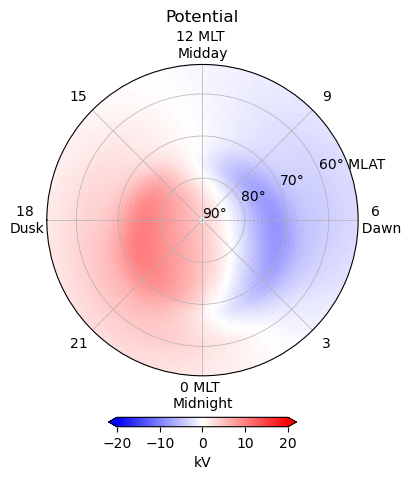

In [36]:
# Define common parameters
theta = np.deg2rad(np.linspace(0, 360, inter_long) - 90)
r = 90 - np.linspace(53.1, 89.7, inter_lat)
shrink = 0.4
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(5, 5))

#potential
mesh1 = ax.pcolormesh(theta, r, combined_ds[feature].mean('dt'), shading='auto', cmap='bwr', vmin=-20, vmax=20)
ax.set_title('Potential')
fig.colorbar(mesh1, ax=ax, label='kV', orientation='horizontal', pad=0.1, shrink=shrink, extend='both')

ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-', linewidth=0.5, zorder=6)

plt.tight_layout()
#space between subplots
